In [72]:
%matplotlib inline
import os
import cv2 as cv
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from skimage.io import imread
import skimage.feature 
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [73]:
in_dir = '5.test_sample'
binary_dir = '6.test_binary'
out_dir = '7.test_tumor_detected'
model_fname = 'model/rf_model.pkl'

In [74]:
print(os.listdir(in_dir))

['benign (1).jpg', 'benign (10).jpg', 'benign (11).jpg', 'benign (12).jpg', 'benign (13).jpg', 'benign (14).jpg', 'benign (15).jpg', 'benign (17).jpg', 'benign (18).jpg', 'benign (19).jpg', 'benign (2).jpg', 'benign (20).jpg', 'benign (21).jpg', 'benign (22).jpg', 'benign (23).jpg', 'benign (24).jpg', 'benign (25).jpg', 'benign (26).jpg', 'benign (27).jpg', 'benign (28).jpg', 'benign (29).jpg', 'benign (3).jpg', 'benign (30).jpg', 'benign (31).jpg', 'benign (32).jpg', 'benign (33).jpg', 'benign (34).jpg', 'benign (35).jpg', 'benign (36).jpg', 'benign (37).jpg', 'benign (38).jpg', 'benign (39).jpg', 'benign (4).jpg', 'benign (40).jpg', 'benign (41).jpg', 'benign (42).jpg', 'benign (43).jpg', 'benign (44).jpg', 'benign (45).jpg', 'benign (46).jpg', 'benign (47).jpg', 'benign (48).jpg', 'benign (49).jpg', 'benign (5).jpg', 'benign (50).jpg', 'benign (51).jpg', 'benign (6).jpg', 'benign (7).jpg', 'benign (8).jpg', 'benign (9).jpg', 'malignant (1).jpg', 'malignant (10).jpg', 'malignant (11)

In [75]:
image_name = 'benign (2).jpg'

In [76]:
Gx= np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [77]:
def detect_tumor( temp_path, output_path):
    img = cv.imread(os.path.join(in_dir,image_name))
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Original Image')
    plt.show()

    orig_img = img
    gray_img = cv.cvtColor( orig_img, cv.COLOR_BGR2GRAY ) 
    median_filtered = cv.medianBlur(gray_img, 5)

    img_sobelx = cv.Sobel(median_filtered,cv.CV_8U,1,0,ksize=3)
    img_sobely = cv.Sobel(median_filtered,cv.CV_8U,0,1,ksize=3)

    img_sobel = img_sobelx + img_sobely + gray_img

    threshold = 137
    maxValue = 255

    th, thresh = cv.threshold(img_sobel, threshold, maxValue, cv.THRESH_BINARY)

    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 1)

    sure_bg = cv.dilate(opening,kernel,iterations=3)
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)

    contours, _ = cv.findContours(sure_fg.copy(),cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

    marker = np.zeros((gray_img.shape[0], gray_img.shape[1]),dtype = np.int32)

    marker = np.int32(sure_fg) + np.int32(sure_bg)

    for id in range(len(contours)):
        cv.drawContours(marker,contours,id,id+2, -1)

    marker = marker + 1

    marker[unknown==255] = 0

    copy_img = orig_img.copy()

    tumor_img = cv.watershed(copy_img, marker)

    copy_img[marker==-1]=(0,0,255)

    plt.imsave(temp_path,tumor_img,cmap='gray')

    t_img = cv.imread(temp_path)

    t_img = cv.cvtColor(t_img, cv.COLOR_BGR2RGB)

    tumor_img_gray = cv.cvtColor( t_img, cv.COLOR_BGR2GRAY )

    ret,tumor_binary_image = cv.threshold(tumor_img_gray,137,1,cv.THRESH_BINARY)
    
    plt.imsave(temp_path,tumor_binary_image,cmap='gray')
    
    plt.imshow(tumor_binary_image, cmap='gray')
    plt.axis('off')
    plt.title('Binary Image')
    plt.show()
    
    orig_img = cv.cvtColor(orig_img, cv.COLOR_RGB2GRAY)
    multi_image = orig_img * tumor_binary_image
    plt.imsave(output_path,multi_image,cmap='gray')
    
    plt.imshow(multi_image, cmap='gray')
    plt.axis('off')
    plt.title('Tumor Image')
    plt.show()

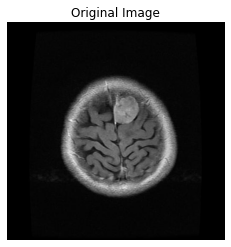

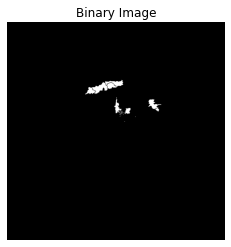

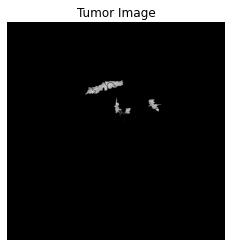

In [78]:

detect_tumor( os.path.join(binary_dir,image_name), os.path.join(out_dir,image_name)) 

In [79]:
labeling_class = {
  0 : "benign",
  1 : "malignant",
  2 : "no_tumor"
}

In [80]:
loaded_forest = pkl.load(open(model_fname,'rb'))

In [81]:
def detect_tumor(img_path):
    
    img = cv.imread(img_path, 0)
    # plt.imshow(img, cmap='gray')
    # plt.axis('off')
    S = preprocessing.MinMaxScaler((0,11)).fit_transform(img).astype(int)

    g = skimage.feature.graycomatrix(S, distances=[1], angles=[0], levels=256, symmetric=False, normed=False)

    contrast = skimage.feature.graycoprops(g, 'contrast')
    energy = skimage.feature.graycoprops(g,'energy')
    homogeneity = skimage.feature.graycoprops(g, 'homogeneity')
    correlation = skimage.feature.graycoprops(g, 'correlation')
    dissimilarity = skimage.feature.graycoprops(g, 'dissimilarity')
    ASM = skimage.feature.graycoprops(g, 'ASM')

    img1 = cv.imread(img_path,0)
    ret,thresh = cv.threshold(img1,127,255,0)
    contours,hierarchy = cv.findContours(thresh, 1, 2)
    cnt = contours[0]

    area = cv.contourArea(cnt)
    perimeter = cv.arcLength(cnt,True)
    epsilon = 0.1*cv.arcLength(cnt,True)
    k = cv.isContourConvex(cnt)
    
    f_arr =  np.asarray([contrast[0][0],energy[0][0],homogeneity[0][0],correlation[0][0],dissimilarity[0][0],ASM[0][0],area,perimeter,epsilon,k])
    features = f_arr.reshape((1,10))
    class_label = loaded_forest.predict(features)[0]
    print('The predicted class label is :', labeling_class[class_label])

In [82]:
detect_tumor(os.path.join(out_dir,image_name))

The predicted class label is : no_tumor


# Done